In [ ]:
# this code is based on https://github.com/peterhessey/DeepLearning/blob/master/dcgan.py, which is released under the MIT licesne
# this code is based on https://github.com/graviraja/pytorch-sample-codes/blob/master/simple_vae.py, which is released under the MIT licesne

# imports
import math
import numpy as np
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision.datasets import CIFAR10
import torch.optim as optim
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt

# hyperparameters
#batch_size  = 64
n_channels  = 3
#latent_size = 512
dataset = 'cifar10'

BATCH_SIZE = 64     # number of data points in each batch
N_EPOCHS = 300       # times to run the model on complete data
INPUT_DIM = 32 * 32 * 3 # size of each input
HIDDEN_DIM = 512    # hidden dimension
LATENT_DIM = 50     # latent vector dimension
lr = 1e-03          # learning rate

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(device)

cuda


In [ ]:
# helper function to make getting another batch of data easier
def cycle(iterable):
    while True:
        for x in iterable:
            yield x

#setting up custom dataset based on CIFAR10 but with only the necessary classes
class PegasusDataset(CIFAR10):
    def __init__(self, root, train=True, transform=None, target_transform=None,download=False):
        super().__init__(root, train, transform, target_transform, download)

        plane_label = 0
        bird_label = 2
        horse_label = 7

        valid_classes = [plane_label, bird_label, horse_label] # index of birds, horses and planes

        pegasus_data = [self.data[i] for i in range(len(self.targets)) if self.targets[i] in valid_classes]

        # print(type(pegasus_data))
        pegasus_targets = [self.targets[i] for i in range(len(self.targets)) if self.targets[i] in valid_classes]

        self.data = pegasus_data
        self.targets = pegasus_targets

# you may use cifar10 or stl10 datasets
if dataset == 'cifar10':
    #class_names = ['airplane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
    #select_classes = ['plane', 'horse', 'bird']
    
    # training dataset
    train_set = PegasusDataset('drive/My Drive/training/cifar10', train=True, download=True, transform=torchvision.transforms.Compose([
            torchvision.transforms.ToTensor()
        ]))

    # testing dataset
    test_set = PegasusDataset('drive/My Drive/training/cifar10', train=False, download=True, transform=torchvision.transforms.Compose([
            torchvision.transforms.ToTensor()
        ]))

    # dataloaders used for easier access to data for training
    train_loader = torch.utils.data.DataLoader(train_set, shuffle=True, batch_size=BATCH_SIZE, drop_last=True)
    test_loader = torch.utils.data.DataLoader(test_set, shuffle=True, batch_size=BATCH_SIZE, drop_last=True)

    '''train_loader = torch.utils.data.DataLoader(
        torchvision.datasets.CIFAR10('drive/My Drive/training/cifar10', train=True, download=True, transform=torchvision.transforms.Compose([
            torchvision.transforms.ToTensor(),
        ])),
        shuffle=True, batch_size=batch_size, drop_last=True
    )'''

train_iterator = iter(cycle(train_loader))
test_iterator  = iter(cycle(test_loader))

#New
train_iteratorA = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True)
test_iteratorA = DataLoader(test_set, batch_size=BATCH_SIZE)


Extracting drive/My Drive/training/cifar10/cifar-10-python.tar.gz to drive/My Drive/training/cifar10
Files already downloaded and verified


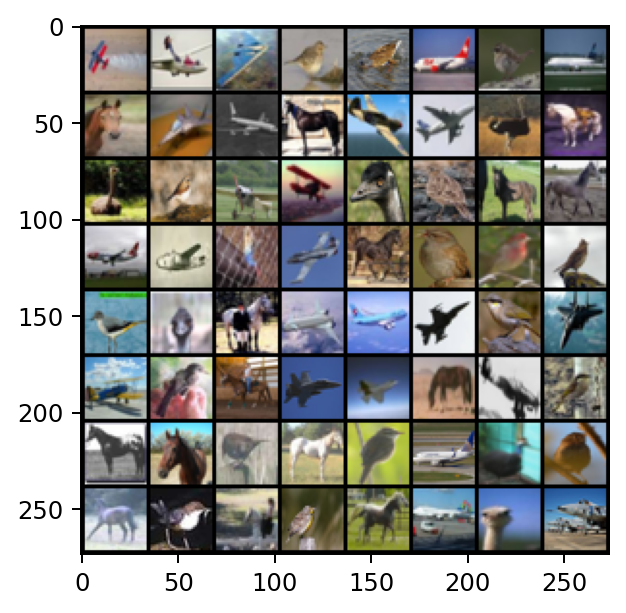

In [ ]:
# let's view some of the training data
plt.rcParams['figure.dpi'] = 175
x,t = next(train_iterator)
x,t = x.to(device), t.to(device)
plt.grid(False)
plt.imshow(torchvision.utils.make_grid(x).cpu().data.permute(0,2,1).contiguous().permute(2,1,0), cmap=plt.cm.binary)
plt.show()

**Define a simple convolutional autoencoder**

In [ ]:
class Encoder(nn.Module):
      ''' This the encoder part of VAE

      '''
      def __init__(self, input_dim, hidden_dim, z_dim):
          '''
          Args:
              input_dim: A integer indicating the size of input (in case of MNIST 28 * 28).
              hidden_dim: A integer indicating the size of hidden dimension.
              z_dim: A integer indicating the latent dimension.
          '''
          super().__init__()

          self.linear = nn.Linear(input_dim, hidden_dim)
          self.mu = nn.Linear(hidden_dim, z_dim)
          self.var = nn.Linear(hidden_dim, z_dim)

      def forward(self, x):
          # x is of shape [batch_size, input_dim]

          hidden = F.relu(self.linear(x))
          # hidden is of shape [batch_size, hidden_dim]
          z_mu = self.mu(hidden)
          # z_mu is of shape [batch_size, latent_dim]
          z_var = self.var(hidden)
          # z_var is of shape [batch_size, latent_dim]

          return z_mu, z_var

class Decoder(nn.Module):
  ''' This the decoder part of VAE

  '''
  def __init__(self, z_dim, hidden_dim, output_dim):
      '''
      Args:
          z_dim: A integer indicating the latent size.
          hidden_dim: A integer indicating the size of hidden dimension.
          output_dim: A integer indicating the output dimension (in case of MNIST it is 28 * 28)
      '''
      super().__init__()

      self.linear = nn.Linear(z_dim, hidden_dim)
      self.out = nn.Linear(hidden_dim, output_dim)

  def forward(self, x):
      # x is of shape [batch_size, latent_dim]

      hidden = F.relu(self.linear(x))
      # hidden is of shape [batch_size, hidden_dim]

      predicted = torch.sigmoid(self.out(hidden))
      # predicted is of shape [batch_size, output_dim]

      return predicted

class VAE(nn.Module):
    ''' This the VAE, which takes a encoder and decoder.

    '''
    def __init__(self, enc, dec):
        super().__init__()

        self.enc = enc
        self.dec = dec

    def forward(self, x):
        # encode
        z_mu, z_var = self.enc(x)

        # sample from the distribution having latent parameters z_mu, z_var
        # reparameterize
        std = torch.exp(z_var / 2)
        eps = torch.randn_like(std)
        x_sample = eps.mul(std).add_(z_mu)

        # decode
        predicted = self.dec(x_sample)
        return predicted, z_mu, z_var

In [ ]:
# encoder
encoder = Encoder(INPUT_DIM, HIDDEN_DIM, LATENT_DIM)

# decoder
decoder = Decoder(LATENT_DIM, HIDDEN_DIM, INPUT_DIM)

# vae
model = VAE(encoder, decoder).to(device)

# optimizer
optimizer = optim.Adam(model.parameters(), lr=lr)

In [ ]:
def train():
      # set the train mode
      model.train()

      # loss of the epoch
      train_loss = 0

      for i, (x, _) in enumerate(train_iteratorA):
          # reshape the data into [batch_size, 3072]
          x = x.view(-1, 32 * 32 * 3)
          x = x.to(device)
          
          # update the gradients to zero
          optimizer.zero_grad()

          # forward pass
          x_sample, z_mu, z_var = model(x)

          # reconstruction loss
          recon_loss = F.binary_cross_entropy(x_sample, x, size_average=False)

          # kl divergence loss
          kl_loss = 0.5 * torch.sum(torch.exp(z_var) + z_mu**2 - 1.0 - z_var)

          # total loss
          loss = recon_loss + kl_loss

          # backward pass
          loss.backward()
          train_loss += loss.item()
          
          # update the weights
          optimizer.step()

      return train_loss

def test():
      # set the evaluation mode
      model.eval()

      # test loss for the data
      test_loss = 0

      # we don't need to track the gradients, since we are not updating the parameters during evaluation / testing
      with torch.no_grad():
          for i, (x, _) in enumerate(test_iteratorA):
              # reshape the data
              x = x.view(-1, 32 * 32 * 3)
              x = x.to(device)

              # forward pass
              x_sample, z_mu, z_var = model(x)

              # reconstruction loss
              recon_loss = F.binary_cross_entropy(x_sample, x, size_average=False)
              
              # kl divergence loss
              kl_loss = 0.5 * torch.sum(torch.exp(z_var) + z_mu**2 - 1.0 - z_var)
              
              # total loss
              loss = recon_loss + kl_loss
              test_loss += loss.item()

      return test_loss


#A = Autoencoder().to(device)
#print(f'> Number of autoencoder parameters {len(torch.nn.utils.parameters_to_vector(A.parameters()))}')
#optimiser = torch.optim.Adam(A.parameters(), lr=0.001)
epoch = 0

**Main training loop**

In [ ]:
best_test_loss = float('inf')

totalTrain = []
totalTest = []
epoch_array = []

for e in range(300):
    train_loss = train()
    test_loss = test()

    train_loss /= len(train_set)
    test_loss /= len(test_set)

    epoch_array.append(e)
    
    totalTrain.append(train_loss)
    totalTest.append(test_loss)

    print(f'Epoch {e}, Train Loss: {train_loss:.2f}, Test Loss: {test_loss:.2f}')

    if best_test_loss > test_loss:
        best_test_loss = test_loss
        patience_counter = 1
    else:
        patience_counter += 1

    #if patience_counter > 3:
        #break

/usr/local/lib/python3.7/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


Epoch 0, Train Loss: 1829.44, Test Loss: 1836.32
Epoch 1, Train Loss: 1829.00, Test Loss: 1839.41
Epoch 2, Train Loss: 1829.39, Test Loss: 1838.79
Epoch 3, Train Loss: 1829.09, Test Loss: 1837.39
Epoch 4, Train Loss: 1828.92, Test Loss: 1838.15
Epoch 5, Train Loss: 1828.79, Test Loss: 1837.11
Epoch 6, Train Loss: 1828.98, Test Loss: 1836.54
Epoch 7, Train Loss: 1829.05, Test Loss: 1838.36
Epoch 8, Train Loss: 1828.80, Test Loss: 1838.31
Epoch 9, Train Loss: 1828.96, Test Loss: 1838.01
Epoch 10, Train Loss: 1828.83, Test Loss: 1837.84
Epoch 11, Train Loss: 1829.05, Test Loss: 1838.34
Epoch 12, Train Loss: 1829.11, Test Loss: 1838.48
Epoch 13, Train Loss: 1828.83, Test Loss: 1838.35
Epoch 14, Train Loss: 1828.80, Test Loss: 1840.05
Epoch 15, Train Loss: 1828.66, Test Loss: 1837.49
Epoch 16, Train Loss: 1828.73, Test Loss: 1837.31
Epoch 17, Train Loss: 1829.13, Test Loss: 1838.52
Epoch 18, Train Loss: 1828.70, Test Loss: 1837.25
Epoch 19, Train Loss: 1828.54, Test Loss: 1836.70
Epoch 20, 

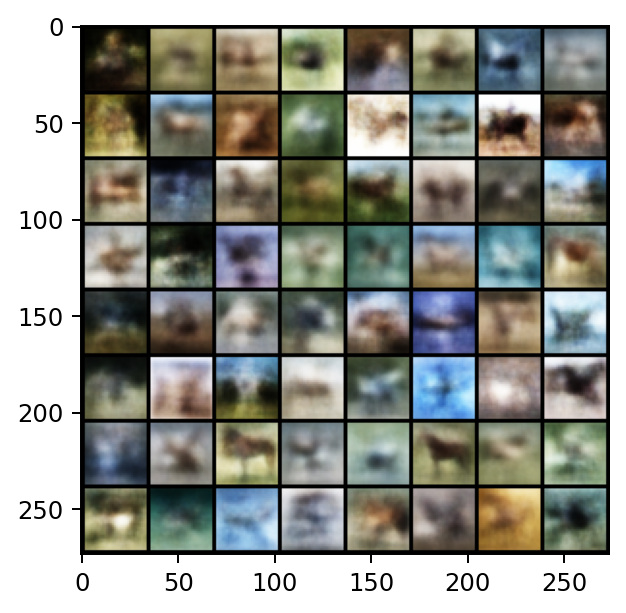

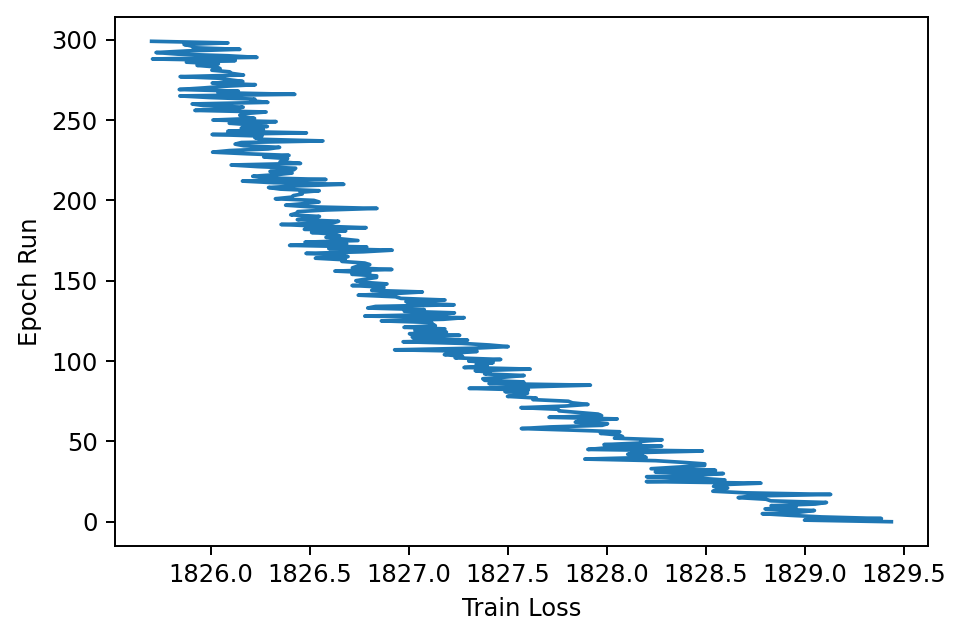

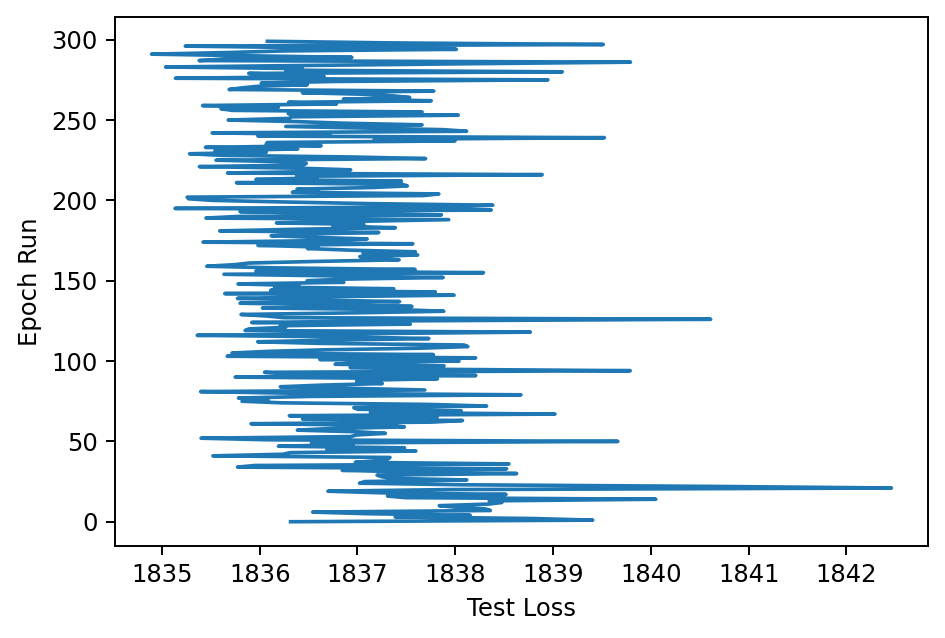

In [ ]:
images = torch.empty(64*3*32*32)
for i in range(64):
    z = torch.randn(1, LATENT_DIM).to(device)
    reconstructed_img = model.dec(z).cpu()
    img = reconstructed_img.view(3*32*32).data
    images[i*3*32*32:(i+1)*3*32*32] = img

images = images.view(64,3,32,32)

plt.rcParams['figure.dpi'] = 175
plt.grid(False)
plt.imshow(torchvision.utils.make_grid(images).cpu().data.permute(0,2,1).contiguous().permute(2,1,0), cmap=plt.cm.binary)
plt.show()

plt.plot(totalTrain, epoch_array)
# naming the x axis 
plt.xlabel('Train Loss') 
# naming the y axis 
plt.ylabel('Epoch Run') 
plt.show()
plt.plot(totalTest, epoch_array)
plt.xlabel('Test Loss') 
# naming the y axis 
plt.ylabel('Epoch Run') 
plt.show() 